YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'Ticker returns'}, xlabel='Date'>

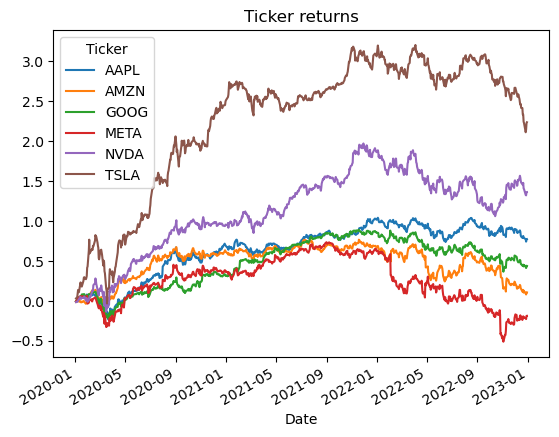

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm

tickers = ['AAPL', 'TSLA', 'NVDA', 'META', 'AMZN', 'GOOG']

prices = yf.download(tickers, start='2020-01-01', end='2023-01-01')['Close']

returns = prices.pct_change().dropna()
spy = yf.download('SPY', start=returns.index[0], end=returns.index[-1])['Close']
spy_returns = spy.pct_change().dropna()
returns.cumsum().plot(title="Ticker Returns")

# Applying a strategy and obtaining returns
A rank demeaned strategy using a 20 day moving average window for the 6 tickers is implemented after which the strategy return streams along with the individual sharpe ratios are obtained.

<Axes: title={'center': 'Strategy returns'}, xlabel='Date'>

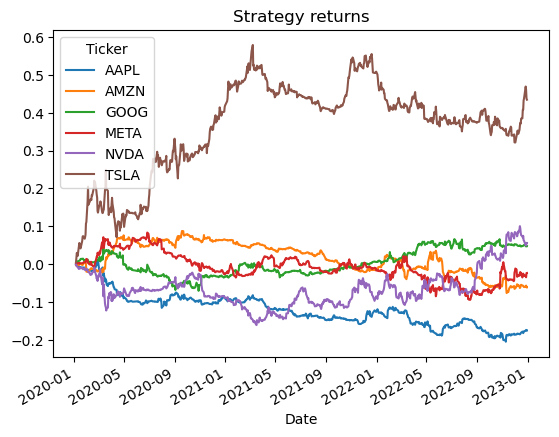

In [2]:
strat = {}
avg_ret = returns.rolling(20, min_periods=1).mean().rank(1)
avg_ret = avg_ret.subtract(avg_ret.mean(1), 0)
avg_ret = avg_ret.divide(avg_ret.abs().sum(1), 0)
strat = (avg_ret.shift()*returns)
strat.cumsum().plot(title="Strategy returns")

In [3]:
sr = (strat.mean()/strat.std())*np.sqrt(252)
print("Sharpe ratios of individual strategies: ", sr)

Sharpe ratios of individual strategies:  Ticker
AAPL   -1.026566
AMZN   -0.318457
GOOG    0.268901
META   -0.085012
NVDA    0.167420
TSLA    0.811732
dtype: float64


# Calculating optimal weights using mean-variance optimization
Optimal weights are calculated using $w = \Sigma^{-1} \times \mu $.

Once the weights are assigned to each strategy, the combined returns stream is calculated by doing a dot product of the weights array and the return stream of the individual strategies

In [5]:
def optimal_weights(sigma, mu):
    weights = np.linalg.inv(sigma) @ mu
    weights = weights / np.abs(weights).sum()
    return weights
sigma = strat.cov()
mu = strat.mean()
weights = optimal_weights(sigma, mu)

<Axes: title={'center': 'Combined Strategy using optimal weights'}, xlabel='Date'>

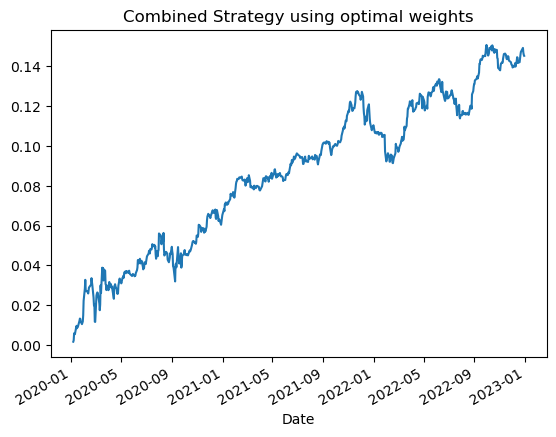

In [7]:
combined_returns = strat @ weights


cum_individual = strat.cumsum()
cum_combined = combined_returns.cumsum()
cum_combined.plot(title = "Combined Strategy using optimal weights")

In [9]:
new_sharpe = (combined_returns.mean()/combined_returns.std())*np.sqrt(252)
print("Sharpe ratio of combined portfolio: ", new_sharpe)

Sharpe ratio of combined portfolio:  1.3959873837030468


# Testing for alpha
Our combined strategy is regressed against the benchmark which is SPY or the S&P500.

In [10]:
combined_returns = combined_returns.loc[spy_returns.index]
X = sm.add_constant(spy_returns)  
model = sm.OLS(combined_returns, X).fit()
print(model.summary())


print("Alpha (annualized):", model.params['const'] * 252)



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     8.346
Date:                Thu, 26 Jun 2025   Prob (F-statistic):            0.00398
Time:                        21:10:13   Log-Likelihood:                 3546.4
No. Observations:                 753   AIC:                            -7089.
Df Residuals:                     751   BIC:                            -7080.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   7.96e-05      2.511      0.0

# Max Drawdown Duration

In [11]:
cum_returns = (1 + combined_returns).cumprod()
running_max = cum_returns.cummax()
drawdown = (cum_returns - running_max) / running_max
max_drawdown = drawdown.min()
print("Max Drawdown:", max_drawdown)

Max Drawdown: -0.035709290574218955
